# MRP Extended Kalman Filter Demo

This demo introduces a JAXitude workflow estimating the attitude evolution of a tumbling spacecraft using simulated data using modified Rodrigues parameters (MRPs).  We'll make use of four JAXitude tools for this exercise:
- `jaxitude.quaternions.Quaternion()` to transform the simulated quaternion data to principal axes and angles,
- `jaxitude.operations.noise.QuatNoise` to appropriately simulate measurement error from the simulated quaternion data,
- `jaxitude.rodrigues.MRP()` to convert simulated attitude measurements to MRPs,
- `jaxitude.determination.eki.MRPEKF` to build the MRP extended Kalman filter algorithm.

As always with JAXitude, any vector data must be transformed to column vectors (I.e. `jnp.array([1., 0., 0.])` $\rightarrow$ `jnp.array([1., 0., 0.]).reshape((3, 1))`).

## Step Zero: Load Simulation Data

We need to import the training data provided under the local directory `data/`.  We'll be using the `tumbling1/` data set for this demo.

In [1]:
from pathlib import Path
import sys
import os
sys.path.append(str(Path(os.getcwd()).parent))
from typing import Tuple

from numpy import genfromtxt
import jax.numpy as jnp
from jax import config
config.update('jax_enable_x64', True)  # Default to double float precision.

data_path = Path('data/') / 'tumbling1'

# Load observed gyroscope data.
with open(data_path / 'gyro-0.csv', 'r') as f:
    w_obs_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Load true gyroscope data.
with open(data_path / 'ref_gyro.csv', 'r') as f:
    w_true_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Load true attitude data (parameterized with quaternions).
with open(data_path / 'ref_att_quat.csv', 'r') as f:
    b_true_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Load true attitude data (parameterized with Euler angles).
with open(data_path / 'ref_att_euler.csv', 'r') as f:
    ea_true_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# load simulation time data.
with open(data_path / 'time.csv', 'r') as f:
    t_data = jnp.asarray(genfromtxt(f, delimiter=',', skip_header=1))

# Remember: all vector data must be transformed to column vectors to utilize
# JAXitude calculations!  Also, convert deg/s to rad/s
n_steps = jnp.shape(t_data)[0]
w_obs_data = w_obs_data.reshape((n_steps, 3, 1)) * jnp.pi / 180.
w_true_data = w_true_data.reshape((n_steps, 3, 1)) * jnp.pi / 180.
b_true_data = b_true_data.reshape((n_steps, 4, 1))
ea_true_data = ea_true_data.reshape((n_steps, 3, 1)) * jnp.pi / 180.

## Step One: Simulate Attitude Measurements

Since the simulated attitudes are parameterized as quaternions, we'll make use of `jaxitude.operations.noise.QuatNoise` to simulate measurement uncertainty


In [2]:
from jax import vmap
from jax.random import PRNGKey, split

from jaxitude.operations.noise import QuatNoise

# We need a random key to generate noise.
key = PRNGKey(1)

# Quaternion rotation angle error standard deviation will be set to five degrees.
sigma_dtheta = 5. * jnp.pi / 180.  # Convert to radians for JAXitude!


# For this helper function, we'll define it for a single key, b argument pair
# and then vectorize with vmap.
@vmap
def addnoise_sample(key: int, b: jnp.ndarray) -> jnp.ndarray:
    """ This helper function takes the quaternion set b, makes sure it is
        normalized, and adds noise.
    """
    # We get the rotation matrix R(b) by calling the instantiated Quaternion
    # object.  Note that we also normalized the quaternion set.
    return QuatNoise.addnoise(key, b / jnp.linalg.norm(b), sigma_dtheta)

# Simulate measured attitude time series.
key, subkey = split(key)
b_obs_data = addnoise_sample(split(subkey, n_steps),b_true_data)


## Step Two: MRP Conversion

Since we are going to feed all this data into an MRP EKF algorithm, we next want to convert the heading measurements to MRPs.  Again, we'll make use of JAXitude to simplify this workflow.

In [3]:
from jaxitude.quaternions import Quaternion
from jaxitude.rodrigues import shadow

# Let's vectorize converting from quaternions to MRPs
@vmap
def mrp_from_quat(b: jnp.ndarray) -> jnp.ndarray:
    """ Wrapper for converting quaternions to MRPs using the Quaternion object.
    """
    s = Quaternion(b).get_s_from_b()
    return jnp.where(
        jnp.linalg.norm(s) < 1.,
        s,
        shadow(s)
    )

mrp_obs_data = mrp_from_quat(b_obs_data)
mrp_true_data = mrp_from_quat(b_true_data)

## Step Three: MRP EKF Algorithm



In [4]:
from scipy.linalg import block_diag
from jax.random import normal
from jax import jit

import importlib
from jaxitude.estimation import ekf
from jaxitude.operations import linearization 
importlib.reload(linearization)
importlib.reload(ekf)
from jaxitude.estimation.ekf import MRPEKF


# The bias should be around three degrees for all gyroscope axes.
b = jnp.full((3, 1), 3. * jnp.pi / 180.)

# Now we define the state vector s.
x = jnp.vstack([mrp_obs_data[0], b])

# Initializing the state covariance matrix P is more difficult.  We will start
# with a diagonal matrix with with sigma_s = 0.01 and sigma_b = 0.05.
sigmap_w = 1e-3
sigmap_b = 0.05
P = block_diag(
    jnp.eye(3) * sigmap_w**2,
    jnp.eye(3) * sigmap_b**2
)

# The noise vector eta is also needed.
key, subkey1, subkey2 = split(key, 3)
eta_w = normal(subkey1, (3, 1)) * sigmap_w
eta_b = normal(subkey1, (3, 1)) * sigmap_b
eta = jnp.vstack([eta_w, eta_b])

# The process noise covariance will simply be the initial state covariance
# estimate.
Q = P.copy()

# The measurement noise is known from our simulated measurements and from
# comparing the gyroscope data.
sigma_w = 6e-4
R_w = jnp.eye(3) * sigma_w**2.
R_s = jnp.eye(3) * sigma_dtheta**2.

# Finally, the time steps are calculated from the data.
dt = t_data[1] - t_data[0]

x_list = []
eta_list = []
P_list = []

@jit
def step(
    x: jnp.ndarray,
    eta: jnp.ndarray,
    P: jnp.ndarray,
    w_obs: jnp.ndarray,
    s_obs: jnp.ndarray
) -> Tuple[jnp.ndarray]:
    """ MRP EKF filter step"""
    return MRPEKF.filter_step(
        x, eta, P, w_obs, s_obs,
        R_w, R_s, Q, dt
    )

for i in range(n_steps):
    x_list.append(x)
    eta_list.append(eta)
    P_list.append(P)

    x, eta, P = step(
        x, eta, P,
        w_obs_data[i] * jnp.pi / 180., mrp_obs_data[i],
    )

x_arr = jnp.array(x_list)
eta_arr = jnp.array(eta_list)
P_arr = jnp.array(P_list)


(-1.0, 1.0)

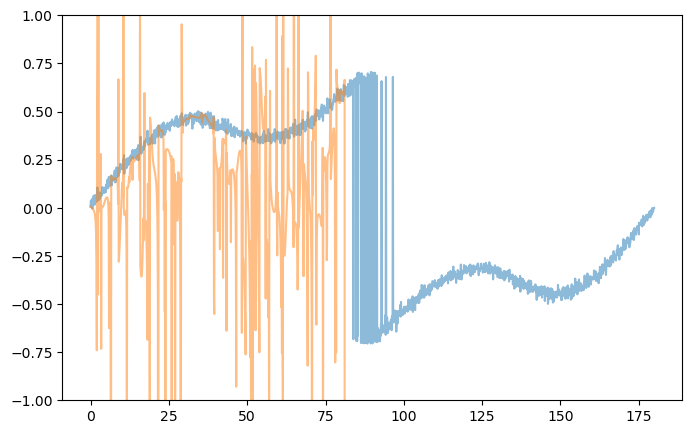

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(t_data[:], mrp_obs_data[:, 2, 0], alpha=0.5)
plt.plot(t_data[:], x_arr[:, 2, 0], alpha=0.5)
plt.ylim(-1., 1.)

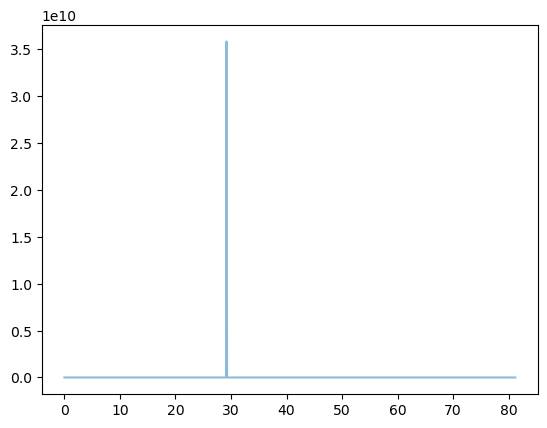

In [6]:
plt.plot(t_data[:], P_arr[:, 0, 0], alpha=0.5)


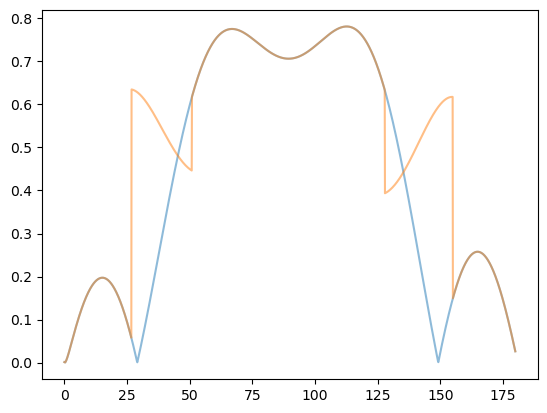

In [7]:
from jaxitude import base
import importlib
importlib.reload(base)

from jaxitude.eulerangles import EulerAngle

@vmap
def ea321_to_b_sample(ea: jnp.ndarray) -> jnp.ndarray:
    return EulerAngle(ea, '321').get_b_short()

b_true_data2 = ea321_to_b_sample(ea_true_data)

plt.plot(t_data, jnp.abs(b_true_data[:, 1, 0]), alpha=0.5)
plt.plot(t_data, jnp.abs(b_true_data2[:, 1, 0]), alpha=0.5)


In [8]:
test = lambda *args: 'asdf'
test(1)

'asdf'